<center>
        <h1>
                Gaussian Frosting: <br>
                Editable Complex Radiance Fields with Real-Time Rendering
        </h1>
        <font size="5">
                ECCV 2024 - Oral<br>
        </font>
        Antoine Guédon and Vincent Lepetit
</center>

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from frosting_scene.gs_model import GaussianSplattingWrapper
from frosting_scene.frosting_model import load_frosting_model

torch.cuda.set_device('cuda:0')
device = torch.device(torch.cuda.current_device())

In [9]:
# Path to your COLMAP dataset. You can change the path to the dataset you want to use.
source_path= './data/mustard'
if source_path[-1] != '/':
    source_path += '/'
your_scene_name = source_path.split('/')[-2]

# Path to the vanilla 3DGS output directory. You can change the path to the directory you want to use.
gs_output_dir = f'./output/vanilla_gs/{your_scene_name}/'

# Path to the Frosting model. You can change the path to the model you want to use.
frosting_dir = f'./output/refined_frosting/{your_scene_name}'
frosting_path = os.path.join(frosting_dir, os.listdir(frosting_dir)[0], '15000.pt')

print("Path to the COLMAP dataset: ", source_path, sep='\n')
print("Path to the vanilla 3DGS output directory: ", gs_output_dir, sep='\n')
print("Path to the Frosting model: ", frosting_path, sep='\n')

Path to the COLMAP dataset: 
./data/mustard/
Path to the vanilla 3DGS output directory: 
./output/vanilla_gs/mustard/
Path to the Frosting model: 
./output/refined_frosting/mustard/frostingfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile01_gauss2000000_frostlevel001_proposal30/15000.pt


## Load corresponding Vanilla 3DGS Model

In [10]:
eval_split = False
load_gt_images = True
white_background = False
bg_color = [1., 1., 1.] if white_background else [0., 0., 0.]

gs_model = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_output_dir if gs_output_dir.endswith(os.sep) else gs_output_dir + os.sep,
    iteration_to_load=7000,
    load_gt_images=load_gt_images,
    eval_split=eval_split,
    eval_split_interval=8,
    background=bg_color,
    white_background=white_background,
    remove_camera_indices=[],
)

Found image extension .png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Rendering image for camera index: 13


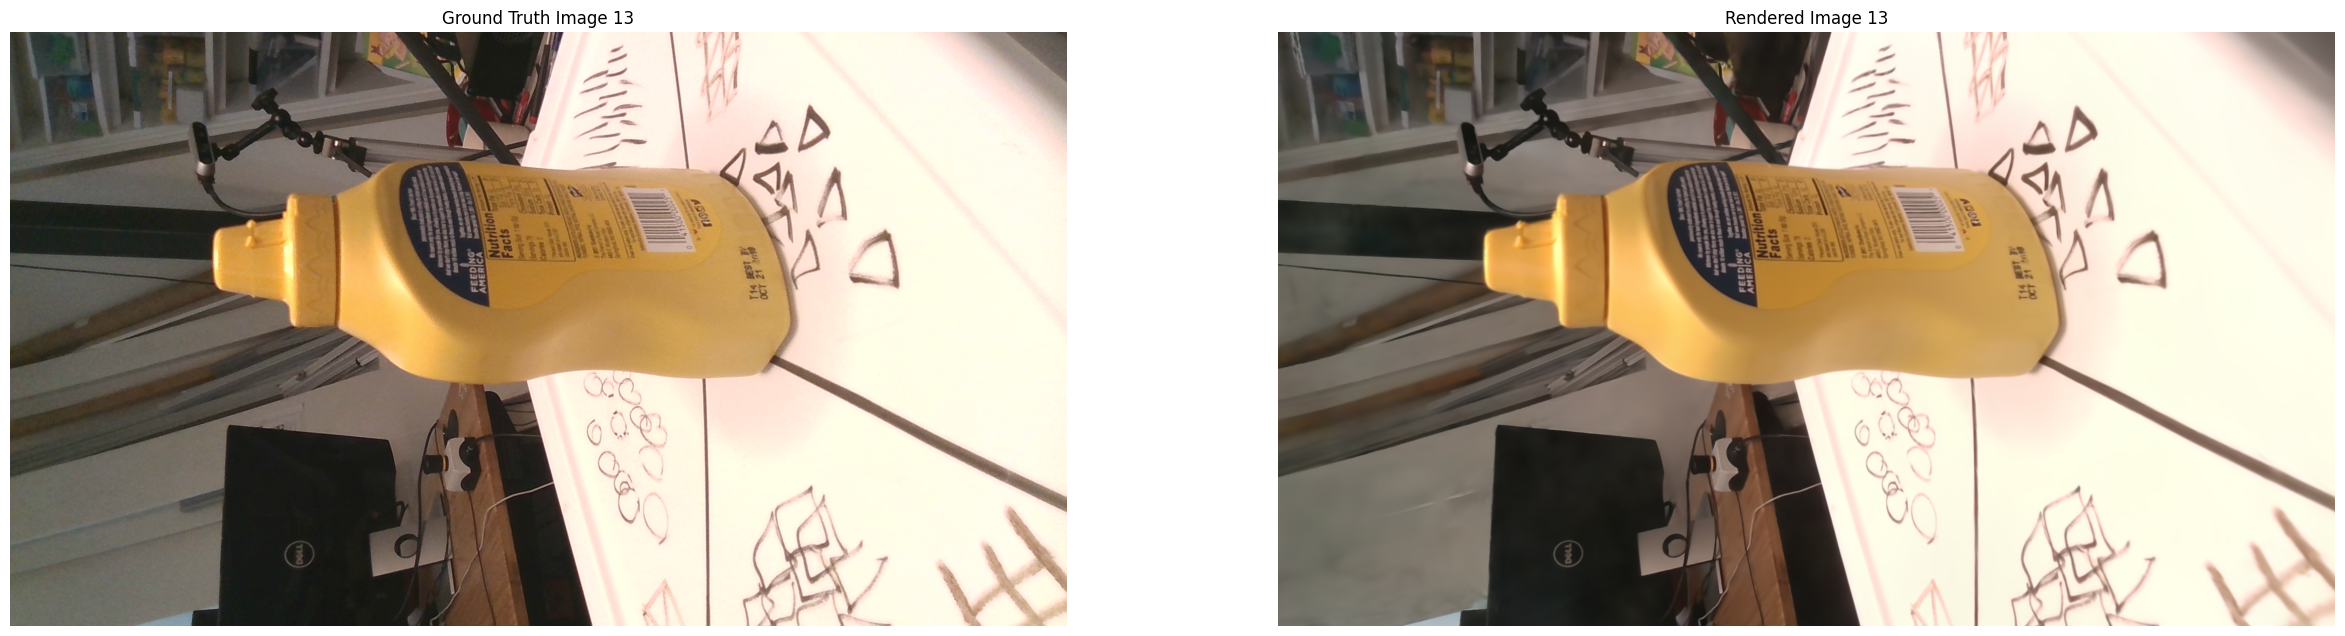

In [11]:
cam_idx = np.random.randint(0, len(gs_model.training_cameras))

print(f'Rendering image for camera index: {cam_idx}')
with torch.no_grad():
    # Render image with the Gaussian Splatting model
    rgb_img = gs_model.render_image(camera_indices=cam_idx).cpu()
    
    # Get GT image if available
    if load_gt_images:
        gt_img = gs_model.get_gt_image(cam_idx).cpu()
    else:
        gt_img = torch.zeros_like(rgb_img)

figsize = 30
height, width = rgb_img.shape[0], rgb_img.shape[1]
plt.figure(figsize=(figsize, figsize * height / width / 2))

plt.subplot(1, 2, 1)
plt.imshow(gt_img)
plt.title(f'Ground Truth Image {cam_idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_img)
plt.title(f'Rendered Image {cam_idx}')
plt.axis('off')

plt.show()

## Load Frosting model

In [12]:
frosting = load_frosting_model(frosting_path, nerfmodel=gs_model)

print(f"Number of vertices in base mesh: {len(frosting._shell_base_verts)}")
print(f"Number of faces in base mesh: {len(frosting._shell_base_faces)}")
print(f"Number of Gaussians in the frosting layer: {len(frosting._bary_coords)}")
if frosting.use_background_gaussians:
    print(f"Number of Gaussians in the background: {len(frosting._bg_points)}")

Creating Frosting model from checkpoint: ./output/refined_frosting/mustard/frostingfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_depthauto_quantile01_gauss2000000_frostlevel001_proposal30/15000.pt
No coarse sugar model provided. The frosting will not be initialized.
Using n_min_gaussian_per_cell=1 (computed automatically).
Frosting loaded.
Number of vertices in base mesh: 736152
Number of faces in base mesh: 1417803
Number of Gaussians in the frosting layer: 2000000
Number of Gaussians in the background: 370693


## Render

In [13]:
# If your model was trained with occlusion culling, set use_occlusion_culling to True.
# Otherwise, set it to False.

# use_occlusion_culling = True
use_occlusion_culling = False

Rendering image 31...


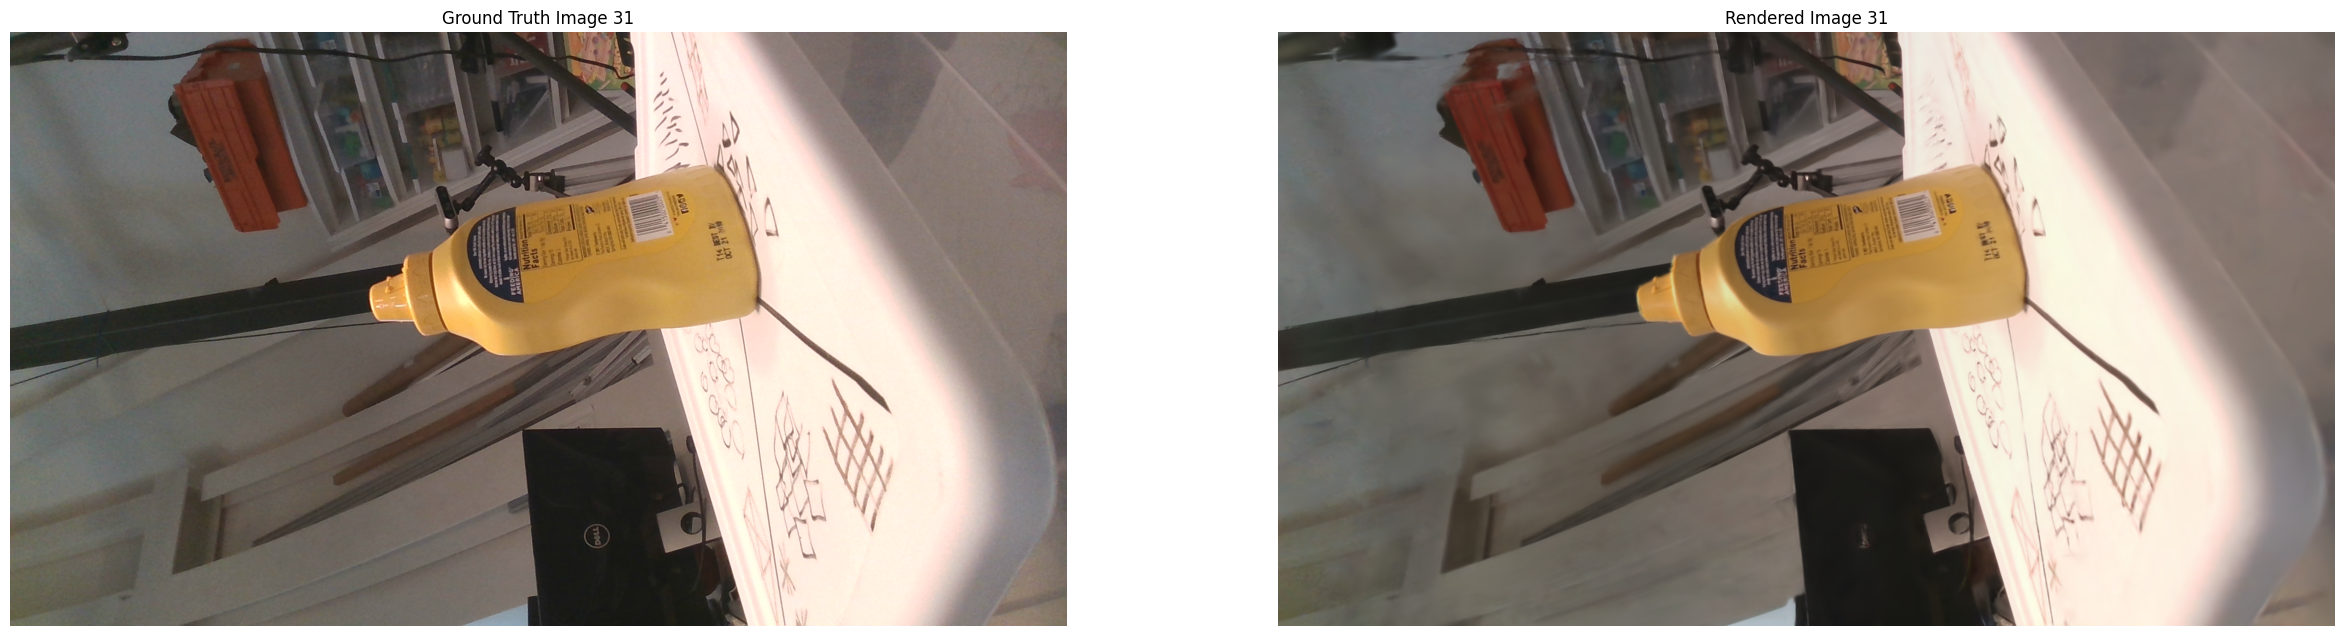

In [22]:
cam_idx = np.random.randint(0, len(gs_model.training_cameras))

print(f"Rendering image {cam_idx}...")
with torch.no_grad():
    # Render RGB image
    rgb_img = frosting.render_image_gaussian_rasterizer(
        camera_indices=cam_idx,
        compute_color_in_rasterizer=True,
        use_occlusion_culling=use_occlusion_culling,
        bg_color=torch.tensor(bg_color, device=device),
    ).clamp(0, 1)
    
    # Get GT image for comparison
    if load_gt_images:
        gt_img = gs_model.get_gt_image(cam_idx).cpu()
    else:
        gt_img = torch.zeros_like(rgb_img)
    
figsize = 30
height, width = rgb_img.shape[0], rgb_img.shape[1]
n_rows, n_cols = 1, 2
if height > width:
    figsize = figsize * width / height
plt.figure(figsize=(figsize, figsize * height / width / n_cols * n_rows))

plt.subplot(n_rows, n_cols, 1)
plt.imshow(gt_img.cpu())
plt.title(f'Ground Truth Image {cam_idx}')
plt.axis('off')

plt.subplot(n_rows, n_cols, 2)
plt.imshow(rgb_img.cpu())
plt.title(f'Rendered Image {cam_idx}')
plt.axis('off')

plt.show()